# Vector Converter Training

Unfortunately, vector converter neural network model hasn't succeeded due to the triplet loss vector collapse. However, maybe there are some regularizers or methods to prevent it

## Step 1. Import needed packages

Importing all the packages we need for our model

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as tf_backend 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Import all other needed packages
import numpy as np
import csv
from PIL import Image
import random
import os
import json
import pandas as pd
import cv2

# Custom packages
from internal import binarer
from internal.estimaters.main import AccuracyEstimator, sigma_score
from internal.data.csv import CSV

%matplotlib inline

Embedding size $N=128$ is our universal constant

In [2]:
embedding_size = 128

## Step 2. Generate train & test datasets

Given the dataset $\mathcal{D} = \{ \{\mathbf{x}_k\}_{k=1}^M, \{y_k\}_{k=1}^M \}$ we split it into two other datasets:

$$
\mathcal{D}_{\text{train}} = \{ \{ \mathbf{x}_k\}_{k=1}^{M_{\eta}}, \{y_k\}_{k=1}^{M_{\eta}} \} 
$$
$$
\mathcal{D}_{\text{test}} = \{ \{ \mathbf{x}_k \}_{k=M_{\eta}}^{M}, \{y_k\}_{k=M_{\eta}}^{M} \}
$$

Where $M_{\eta}=\lfloor0.8M\rfloor$ is a proportion we allocate for a train part of the dataset

Here we simply import our $\texttt{csv}$ file and import all the vectors into $\texttt{feature_vector_batches_np}$, $\texttt{feature_vector_batches_tf}$, and $\texttt{labels}$.

In [3]:
# Loading our dataset
X, Y, links = CSV(input_path='./csv_datasets/face_recognition_celeba.csv').read()

# Converting X to a tensor
X = tf.convert_to_tensor(X)

dataset_size = len(X)
print('Dataset size is', dataset_size)

Y_unique = np.unique(Y)
print('Number of unique classes:', len(Y_unique))

Dataset size is 196855
Number of unique classes: 10173


2023-02-19 13:47:15.769396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 13:47:15.770793: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We split into the test and train datasets according to the number of classes proportion

In [4]:
# Ratio of classes selected for training a model
test_proportion = 0.8

Y_unique_train_size = int(len(Y_unique) * test_proportion)
Y_unique_train = Y_unique[:Y_unique_train_size]
Y_unique_test = Y_unique[Y_unique_train_size:]

X_train, Y_train, links_train = [], [], []
for c in Y_unique_train:
    indices = [i for i in range(dataset_size) if Y[i] == c]
    for i in indices:
        X_train.append(X[i])
        Y_train.append(Y[i])
        links_train.append(links[i])

Train = (X_train, Y_train, links_train)

X_test, Y_test, links_test = [], [], []
for c in Y_unique_test:
    indices = [i for i in range(dataset_size) if Y[i] == c]
    for i in indices:
        X_test.append(X[i])
        Y_test.append(Y[i])
        links_test.append(links[i])
        
Test = (X_test, Y_test, links_test)
print('Size of a train dataset is', len(X_train))
print('Size of a test dataset is', len(X_test))

Size of a train dataset is 159527
Size of a test dataset is 37328


Let us draw some images to verify that everything was loaded fine

In [5]:
def visualize_images(image_links):
    plt.figure(figsize=(5, 2))
    images_num = len(image_links)
    for i, link in enumerate(image_links):
        image = cv2.cvtColor(cv2.imread(link), cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, images_num, i+1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")

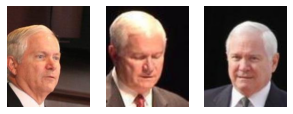

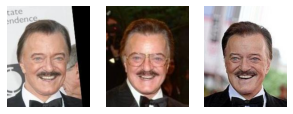

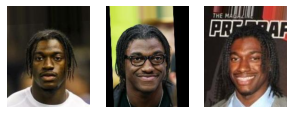

In [6]:
test_uniques = np.unique(Y_test)

links_1 = [links_test[i] for i in range(len(Y_test)) if Y_test[i] == test_uniques[0]]
links_2 = [links_test[i] for i in range(len(Y_test)) if Y_test[i] == test_uniques[1]]
links_3 = [links_test[i] for i in range(len(Y_test)) if Y_test[i] == test_uniques[2]]

visualize_images(links_1[:3])
visualize_images(links_2[:3])
visualize_images(links_3[:3])

## Step 3. Define distance function

Continuous binary distance is defined as follows:
$$
\hat{\delta}(\mathbf{x}, \mathbf{y}) = \frac{1}{N}\sum_{k=1}^N |x_k - y_k|
$$

In [7]:
# Check binary distance formula
s1 = tf.constant([0.0, 0.0, 1.0, 1.0])
s2 = tf.constant([0.0, 0.0, 1.0, 0.0])
print(binarer.binary_distance(s1, s2))

x = tf.constant([0.001, 0.98, 0.1, 0.2, 0.78])
print(binarer.to_binary_string(x, 0.5*np.ones(shape=(5,))))

tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor([0. 1. 0. 0. 1.], shape=(5,), dtype=float32)


## Step 4. Creating functions to create batches & triplets

In [8]:
class Batcher:
    """
    Batcher is a class responsible for creating batches and triplets
    """
    def __init__(self, Test, Train, loss=None, model=None):
        """
        __init__ takes the whole dataset and model as an arguments. Model is optional if one uses only 
        create_random_batch function
        """
        self.X_test = Test[0]
        self.Y_test = Test[1]
        self.links_test = Test[2]
        
        self.X_train = Train[0]
        self.Y_train = Train[1]
        self.links_train = Train[2]
        
        self.loss = loss
        self.model = model
        
    def form_random_batch(self, batch_size=256, split="train"):
        """
        create_random_batch forms {batch_size} triplets depending on a split.
        
        Input:
        batch_size - size of a batch
        split - either 'train' or 'test'
        
        Output:
        A tuple with anchors, positives, and negatives vectors
        A tuple with anchors, positives, and image links
        """
        
        x_anchors, x_positives, x_negatives = [], [], []
        y_anchors, y_positives, y_negatives = [], [], []
        links_anchors, links_positives, links_negatives = [], [], []
        
        X, Y, links = [], [], []
        
        if split == "train":
            X = self.X_train
            Y = self.Y_train
            links = self.links_train
        elif split == "test":
            X = self.X_test
            Y = self.Y_test
            links = self.links_test

        for i in range(0, batch_size):
            # We need to find an anchor, a positive example and a negative example
            random_index = 0
            positive_indices = []
            negative_indices = []
            
            while len(positive_indices) == 0 or len(negative_indices) == 0:
                random_index = random.randint(0, len(Y) - 1)
                y_anchor = Y[random_index]
                positive_indices = [i for i in range(len(Y)) if y_anchor == Y[i] and i != random_index]
                negative_indices = [i for i in range(len(Y)) if y_anchor != Y[i]]
            
            # Anchor
            x_anchor = X[random_index]
            y_anchor = Y[random_index]
            link_anchor = links[random_index]

            random_positive_index = positive_indices[random.randint(0, len(positive_indices) - 1)]
            random_negative_index = negative_indices[random.randint(0, len(negative_indices) - 1)]
            
            # Positive
            x_positive = X[random_positive_index]
            y_positive = Y[random_positive_index]
            link_positive = links[random_positive_index]
            
            # Negative
            x_negative = X[random_negative_index]
            y_negative = Y[random_negative_index]
            link_negative = links[random_negative_index]
            
            # Appending Xs
            x_anchors.append(x_anchor)
            x_positives.append(x_positive)
            x_negatives.append(x_negative)
            
            # Appending Ys
            y_anchors.append(y_anchor)
            y_positives.append(y_positive)
            y_negatives.append(y_negative)
            
            # Appending links
            links_anchors.append(link_anchor)
            links_positives.append(link_positive)
            links_negatives.append(link_negative)

        return [x_anchors, x_positives, x_negatives], [y_anchors, y_positives, y_negatives], [links_anchors, links_positives, links_negatives]
    
    def form_semi_hard_batch(self, batch_size, hard_size, split="train"):
        """
        create_hard_batch forms {batch_size} semi-hard triplets depending on a split.
        
        Input:
        batch_size - size of a batch
        split - either 'train' or 'test'
        
        Output:
        A tuple with anchors, positives, and negatives vectors
        A tuple with anchors, positives, and negatives images
        """
        if self.model is None:
            print('Model is required!')
            return None
        
        x_anchors = np.zeros((batch_size, 128))
        x_positives = np.zeros((batch_size, 128))
        x_negatives = np.zeros((batch_size, 128))
        links_anchors, links_positives, links_negatives = [], [], []
        X, Y, links = [], [], []
        
        if split == "train":
            X = self.X_train
            Y = self.Y_train
            links = self.links_train
        elif split == "test":
            X = self.X_test
            Y = self.Y_test
            links = self.links_train

        # Generate 'hard' number of hard examples:
        hard_vectors, hard_links, losses = [], [], []
        
        # Generate 'batch_size - hard' number of random examples:
        random_vectors, random_links = [], []
        
        # Get some random batches
        for i in range(batch_size):
            triplet, _, triplet_links = self.form_random_batch(batch_size=1, split=split) 
            
            hard_vectors.append(triplet)
            hard_links.append(triplet_links)
            
            # Calculating a lose value
            concatenated = np.concatenate([triplet[0], triplet[1], triplet[2]], axis=1)
            loss = tf.reduce_sum(self.loss(np.zeros((1, 3*embedding_size)), concatenated))
            losses.append(loss)
        
        # Sort batch_loss by distance, highest first, and keep 'hard' number of them
        losses, hard_vectors, hard_links = zip(*sorted(zip(losses, hard_vectors, hard_links), key=lambda i: i[0], reverse=True))
        
        hard_vectors = hard_vectors[:hard_size]
        hard_links = hard_links[:hard_size]

        # Get batch_size-hard number of random examples
        random_size = batch_size - hard_size
        for i in range(0, random_size):
            triplet, _, triplet_links = self.form_random_batch(1, split)
            random_vectors.append(triplet)
            random_links.append(triplet_links)
        
        selected_vectors = np.concatenate([hard_vectors, random_vectors])
        selected_links = np.concatenate([hard_links, random_links])
        
        for i in range(len(selected_vectors)):
            x_anchors[i] = selected_vectors[i][0]
            x_positives[i] = selected_vectors[i][1]
            x_negatives[i] = selected_vectors[i][2]
            
            links_anchors.append(selected_links[i][0][0])
            links_positives.append(selected_links[i][1][0])
            links_negatives.append(selected_links[i][2][0])

        return [x_anchors, x_positives, x_negatives], [links_anchors, links_positives, links_negatives]

## Step 5. Creating SNN

The neural network has the following structure:

![title](images/internal/triplet_loss.png)

In [9]:
def EmbeddingModel(regularizer=1e-3, hidden_layer_size=20):
    """
    Embedding model is a target model that we need to train to make predictions.
    
    Input:
    regularizer - a value of L2 regularizer in the first layer
    hidden_layer_size - size of a hidden layer
    
    Output:
    Embedding model
    """
    
    embedding_model = keras.Sequential([
        layers.Dense(
            hidden_layer_size,
            input_shape=(embedding_size,),
            name='input_layer',
            activation='relu',
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            kernel_regularizer=l2(regularizer)),
        layers.Dense(
            embedding_size,  
            name="output_layer",
            activation='sigmoid',
        )])
    
    embedding_model.summary()
    return embedding_model

def SNN(embedding_model):
    """
    Siamese neural network is used for training Embedding model and uses three inputs: 
    anchor, positive, and negative 
    
    Input:
    embedding_model - embedding model generated by the function above
    
    Output:
    Siamese Neural Network and summary() output
    """
    
    input_anchor = layers.Input(shape=(embedding_size,))
    input_positive = layers.Input(shape=(embedding_size,))
    input_negative = layers.Input(shape=(embedding_size,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
    
    siamese_net = keras.models.Model([input_anchor, input_positive, input_negative], output)
    siamese_net.summary()
    
    return siamese_net

## Step 6. Loss Functions

### Triplet loss cross-entropy function
We define the binary cross-entropy loss as follows:
$$
\hat{\mathcal{L}}(\Psi \mid \mathcal{T}) = -\sum_{\mathbf{x}^a, \mathbf{x}^p, \mathbf{x}^n \in \mathcal{T}} \log\left[ \delta(\Psi\mathbf{x}^a, \Psi\mathbf{x}^n)\sigma(\Psi\mathbf{x}^a, \Psi\mathbf{x}^p) \right] 
$$

In [11]:
hidden_layer_size = 32
epochs = 10
batch_size = 64
hard_number = 32
learning_rate = 0.001
validation_steps = 20
optimiser = 'Adam'
steps_per_epoch = 50
d0 = int(128/4)

In [12]:
def cross_entropy_loss(y_true, y_pred):
    anchor = y_pred[:,:embedding_size][:d0]
    positive = y_pred[:,embedding_size:(2*embedding_size)][:d0]
    negative = y_pred[:,(2*embedding_size):][:d0]
    
    positive_distance = tf.reduce_mean(tf.abs(anchor - positive), axis=0)
    negative_distance = tf.reduce_mean(tf.abs(anchor - negative), axis=0)
    log_values = -tf.experimental.numpy.log2(tf.multiply(negative_distance, 1.0-positive_distance))
    return tf.reduce_mean(log_values)

### Triplet loss modulus function

We define two losses: distance loss, defined as:
$$
\mathcal{L}_{\delta}(\Psi \mid \mathbf{x}^a, \mathbf{x}^p, \mathbf{x}^n, \Theta) = \left[\delta(\Psi \mathbf{x}^a, \Psi \mathbf{x}^p) - \delta(\Psi \mathbf{x}^a, \mathbf{x}^n) + \Theta\right]_+
$$

Which on the batch is defined as:
$$
\mathcal{L}_{\delta}(\Psi \mid \mathcal{T}, \Theta) = \frac{\sum_{\mathbf{x}^a, \mathbf{x}^p, \mathbf{x}^n \in \mathcal{T}}\delta(\mathbf{x}^a, \mathbf{x}^p) - \delta(\mathbf{x}^a, \mathbf{x}^n)}{\frac{1}{|\mathcal{T}|}\sum_{\mathbf{x}^a,\mathbf{x}^n \in \mathcal{T}}\delta(\mathbf{x}^a, \mathbf{x}^n)}
$$

And epsilon-loss:
$$
\mathcal{L}_{\epsilon}(\Psi \mid \mathbf{x}^a, \mathbf{x}^p, \mathbf{x}^n, \epsilon, \epsilon_m) = \epsilon_m \sum_{x \in \mathbf{x}^a \| \mathbf{x}^p \| \mathbf{x}^n} [\epsilon - |x - 0.5|]_+
$$

Total loss is then:
$$
\mathcal{L} = \mu \mathcal{L}_{\delta} + (1-\mu)\mathcal{L}_{\epsilon}
$$

In [13]:
Theta = 0.4
p = 10.0
sigma = 20.0

def distance_loss(y_true, y_pred):
    anchor = y_pred[:,:embedding_size][:d0]
    positive = y_pred[:,embedding_size:(2*embedding_size)][:d0]
    negative = y_pred[:,(2*embedding_size):][:d0]
    
    positive_distances = tf.reduce_mean(tf.abs(anchor - positive), axis=0)
    negative_distances = tf.reduce_mean(tf.abs(anchor - negative), axis=0)
    
    return tf.maximum(positive_distances - negative_distances + Theta, 0.01)

## Step 6. Setting up for training and evaluation

In [15]:
with tf.device("/cpu:0"):
    print("Generating embedding model...")
    # Create the embedding model
    embedding_model = EmbeddingModel(hidden_layer_size=hidden_layer_size)

    print("Generating SNN...")
    # Create the SNN
    siamese_model = SNN(embedding_model)
    # Compile the SNN
    optimizer = Adam(lr=learning_rate)
    siamese_model.compile(loss=distance_loss, optimizer=optimizer)

Generating embedding model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 32)                4128      
                                                                 
 output_layer (Dense)        (None, 128)               4224      
                                                                 
Total params: 8,352
Trainable params: 8,352
Non-trainable params: 0
_________________________________________________________________
Generating SNN...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                      

## Step 7. Testing batcher

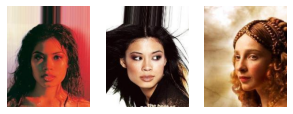

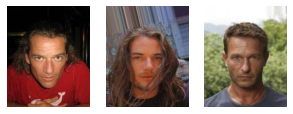

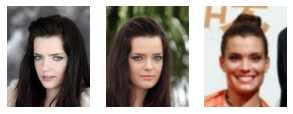

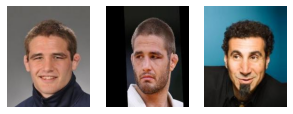

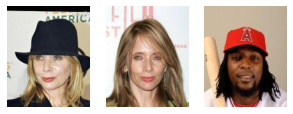

In [16]:
batcher = Batcher(Test, Train, loss=distance_loss, model=embedding_model)

test_batch_size = 5
vectors, labels, links = batcher.form_random_batch(test_batch_size, 'test')
for i in range(test_batch_size):
    visualize_images([links[0][i], links[1][i], links[2][i]])

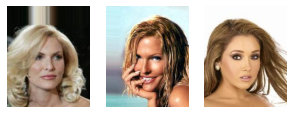

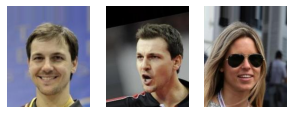

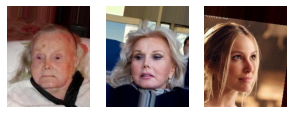

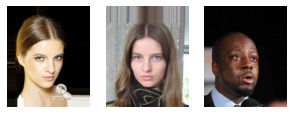

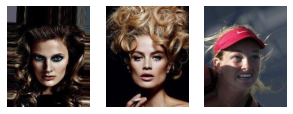

In [17]:
test_batch_size = 5
test_hard = 3
vectors, links = batcher.form_semi_hard_batch(test_batch_size, test_hard, 'test')

for i in range(test_batch_size):
    visualize_images([links[0][i], links[1][i], links[2][i]])

## Step 8. Logging

Used from this medium article: https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463

In [18]:
# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOG",dt)

## Use a custom non-dt name:
name = "snn-run"
logdir = os.path.join("./models/BinNet3",name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.verbose == 1:
                print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current
            
            # Delete the last best emb_model and snn_model
            delete_older_model_files(filepath)

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_model.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : validation_steps, 
               'num_hard' : hard_number, 
               'optimiser' : optimiser,
               'lr' : learning_rate,
               'emb_size' : embedding_size
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_model)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)
    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [file.split("-")[1].split(".h5")[0] for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = emb_model_files_epoch_nums[-1]

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if highest_epoch_num not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file:", emb_model_files_without_highest)
        for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
            for file in model_file_list:
                os.remove(os.path.join(model_dir, file))

## Step 9. Training

In [19]:
def data_generator(batch_size=batch_size, hard_number=hard_number, split="train"):
    while True:
        x, _ = batcher.form_semi_hard_batch(batch_size, hard_number, split)
        y = np.zeros((batch_size, 3*embedding_size))
        yield x, y

In [20]:
## Training:
print("Logging out to Tensorboard at:", logdir)
print("Starting training process!")
print("-------------------------------------")

siamese_history = siamese_model.fit(
data_generator(batch_size, hard_number),
steps_per_epoch=steps_per_epoch,
epochs=epochs,
verbose=1,
callbacks=callbacks, 
workers=0, 
validation_data = data_generator(int(batch_size), hard_number, split="train"), 
validation_steps = validation_steps)

print("-"*30)
print("Training complete.")

Logging out to Tensorboard at: ./models/BinNet3/snn-run
Starting training process!
-------------------------------------
Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.4338
Epoch 1: val_loss improved from inf to 0.42066, saving model to ./models/BinNet3/snn-run/snn_model-01-0.42.h5
Saving embedding model weights at ./models/BinNet3/snn-run/emb_model-01.h5
Deleting previous best model file: ['emb_model-01.h5']
50/50 [==============================] - 259s 5s/step - loss: 0.4338 - val_loss: 0.4207
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.4084
Epoch 2: val_loss improved from 0.42066 to 0.39334, saving model to ./models/BinNet3/snn-run/snn_model-02-0.39.h5
Saving embedding model weights at ./models/BinNet3/snn-run/emb_model-02.h5
Deleting previous best model file: ['emb_model-02.h5']
50/50 [==============================] - 292s 6s/step - loss: 0.4084 - val_loss: 0.3933
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0

Print the plot with dependency of loss on epoch

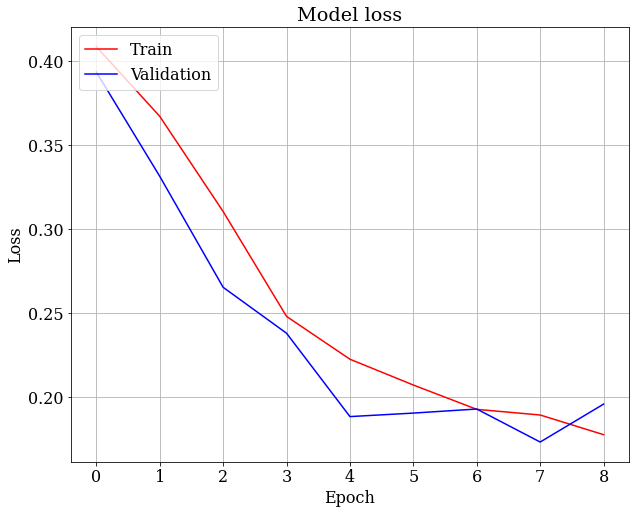

In [21]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.figure(figsize=(10, 8))
plt.plot(siamese_history.history['loss'][1:], color='red')
plt.plot(siamese_history.history['val_loss'][1:], color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()

plt.show()

## Step 10. Analyzing model accuracy

Loading the model:

In [23]:
embedding_weights_src = './models/BinNet3/snn-run/emb_model-09.h5'

loaded_embedding_model = EmbeddingModel(hidden_layer_size=hidden_layer_size)
loaded_embedding_model.load_weights(embedding_weights_src)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 32)                4128      
                                                                 
 output_layer (Dense)        (None, 128)               4224      
                                                                 
Total params: 8,352
Trainable params: 8,352
Non-trainable params: 0
_________________________________________________________________


Anchor: tf.Tensor(
[0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1.], shape=(128,), dtype=float32)
Positive: tf.Tensor(
[0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1.], shape=(128,), dtype=float32)
Negative: tf.Tensor(
[1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1.

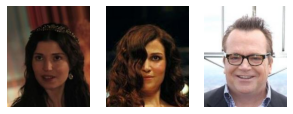

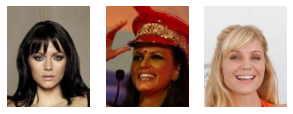

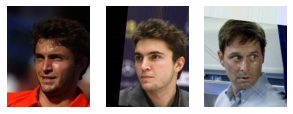

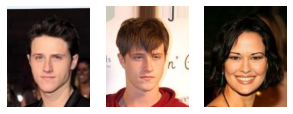

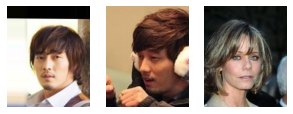

In [25]:
test_batch_size = 5
vectors, labels, links = batcher.form_random_batch(test_batch_size, 'test')

predicted_anchors = embedding_model(tf.convert_to_tensor(vectors[0]))
predicted_positives = embedding_model(tf.convert_to_tensor(vectors[1]))
predicted_negatives = embedding_model(tf.convert_to_tensor(vectors[2]))

for i in range(test_batch_size):
    visualize_images([links[0][i], links[1][i], links[2][i]])
    anchor_string = binarer.to_binary_string(predicted_anchors[i], 0.5*np.ones(shape=(embedding_size,)))
    positive_string = binarer.to_binary_string(predicted_positives[i], 0.5*np.ones(shape=(embedding_size,)))
    negative_string = binarer.to_binary_string(predicted_negatives[i], 0.5*np.ones(shape=(embedding_size,)))
    
    print('Anchor:', anchor_string)
    print('Positive:', positive_string)
    print('Negative:', negative_string)
    print('Same:', tf.reduce_mean(tf.abs(anchor_string-positive_string)))
    print('Diff:', tf.reduce_mean(tf.abs(anchor_string-negative_string)))

In [23]:
# Defining converter using our model
converter = lambda x: binarer.to_binary_string(loaded_embedding_model.predict(x[None,...]), 0.5*np.ones(shape=(128,)))[0]

print('Prediction:', converter(X_test[0]))
print('Prediction:', converter(X_test[8000]))

Prediction: tf.Tensor(
[0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0.], shape=(128,), dtype=float32)
Prediction: tf.Tensor(
[0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 0.], shape=(128,), dtype=float32)


In [ ]:
estimator = AccuracyEstimator(X_test[:2000], Y_test[:2000])

sigma_same, sigma_diff, score = estimator.estimate(converter)

data = [['Zero vector', sigma_same[0], sigma_same[1], sigma_diff[0], sigma_diff[1], score]]
pd.DataFrame(data, columns=["Threshold type", "Sigma same", "# of same pairs", "Sigma diff", "# of diff pairs", "Sigma score"])

## Testing model on test images

### 1. Distance between my images :)

In [ ]:
from internal.data.csv import CSV
from internal.data.celeba import CelebaLoader
from internal.converters.factory import ConverterType, ConverterFactory
import cv2

facenet_converter = ConverterFactory(model=None).get_converter(converter=ConverterType.FACE_RECOGNITION)
facenet_converter_function = facenet_converter.convert_to_feature_vector

def convert_to_binary_string(img_path: str) -> list:
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    vector = facenet_converter_function(image)
    binary_string = binarer.to_binary_string(loaded_embedding_model.predict(vector[None,...]), 0.5*np.ones(shape=(128,)))
    return binary_string

def convert_to_vector(img_path: str) -> list:
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    vector = facenet_converter_function(image)
    return vector

def visualize(image1, image2, string1, string2):
    """
    Function that shows two images and prints two binary strings
    Input:
    image1, image2 - two images
    string1, string2 - two binary strings
    """

    plt.figure(figsize=(5, 2))
    # Drawing first picture
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image1.astype("uint8"))
    plt.axis("off")
    # Drawing second picture
    ax = plt.subplot(1, 3, 2)
    plt.imshow(image2.astype("uint8"))
    plt.axis("off")
    # Drawing a distance between them
    ax = plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, float(tf.reduce_mean(tf.abs(string1-string2))), fontsize='xx-large')
    plt.axis("off")

dima_1_img = cv2.cvtColor(cv2.imread('./images/test/Dima1.png'), cv2.COLOR_BGR2RGB)
dima_2_img = cv2.cvtColor(cv2.imread('./images/test/Dima2.png'), cv2.COLOR_BGR2RGB)
dima_3_img = cv2.cvtColor(cv2.imread('./images/test/Dima3.png'), cv2.COLOR_BGR2RGB)
dima_4_img = cv2.cvtColor(cv2.imread('./images/test/Dima4.png'), cv2.COLOR_BGR2RGB)

dima_1_string = convert_to_binary_string('./images/test/Dima1.png')
dima_2_string = convert_to_binary_string('./images/test/Dima2.png')
dima_3_string = convert_to_binary_string('./images/test/Dima3.png')
dima_4_string = convert_to_binary_string('./images/test/Dima4.png')

print(dima_1_string)
print(dima_2_string)
print(dima_3_string)
print(dima_4_string)

visualize(dima_1_img, dima_2_img, dima_1_string, dima_2_string)
visualize(dima_1_img, dima_3_img, dima_1_string, dima_3_string)
visualize(dima_2_img, dima_3_img, dima_2_string, dima_3_string)
visualize(dima_3_img, dima_4_img, dima_3_string, dima_4_string)
visualize(dima_1_img, dima_4_img, dima_1_string, dima_4_string)

### 2. Distance between my friend's images 

In [ ]:
artem_1_img = cv2.cvtColor(cv2.imread('./images/test/Artem_1.png'), cv2.COLOR_BGR2RGB)
artem_2_img = cv2.cvtColor(cv2.imread('./images/test/Artem_2.png'), cv2.COLOR_BGR2RGB)

artem_1_string = convert_to_binary_string('./images/test/Artem_1.png')
artem_2_string = convert_to_binary_string('./images/test/Artem_2.png')

print(artem_1_string)
print(artem_2_string)

visualize(artem_1_img, artem_2_img, artem_1_string, artem_2_string)
visualize(dima_1_img, artem_2_img, dima_1_string, artem_2_string)

$$
\mathcal{L}(W,\beta) = -\sum_{\mathbf{x}^a, \mathbf{x}^p, \mathbf{x}^n \in \mathcal{T}} \log\left[ \delta(\Psi\mathbf{x}^a, \Psi\mathbf{x}^n)\sigma(\Psi\mathbf{x}^a, \Psi\mathbf{x}^p) \right] 
$$